In [1]:
setwd("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Analysis/MEA-seq/WGCNA_sPLSR")

In [2]:
library(tibble)
library(dplyr)
library(tidyr)
library(ggplot2)
library(tidyverse)
library(DESeq2)
library(tidyverse)
library(WGCNA)
library(mixOmics)
library(writexl)
library(RColorBrewer)


Warning message:
"package 'tibble' was built under R version 4.2.3"
Warning message:
"package 'dplyr' was built under R version 4.2.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'tidyr' was built under R version 4.2.3"
Warning message:
"package 'tidyverse' was built under R version 4.2.3"
Warning message:
"package 'readr' was built under R version 4.2.3"
Warning message:
"package 'purrr' was built under R version 4.2.3"
Warning message:
"package 'stringr' was built under R version 4.2.3"
Warning message:
"package 'forcats' was built under R version 4.2.3"
Warning message:
"package 'lubridate' was built under R version 4.2.3"
── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ lubridate 1.9.3     

In [3]:
MEA_var<-read.csv("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Analysis/MEA-seq/patients_normalized_hier_PC13.csv")
mea_seq_samples<-MEA_var$sample
MEA_var<-MEA_var[-length(MEA_var)]#remove cluster variable, not used for this analysis

In [4]:
counts<-read.table("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Analysis/RNA-seq/PRPS_integration_neurons/ruviii.2000.norm_voom.txt")
rownames(counts)<-counts$Gene
counts <- counts[, -ncol(counts)]
#replace "." to "-" for colnames
colnames_counts<-colnames(counts)
colnames_counts<-gsub("\\.", "-", colnames_counts)
colnames_counts<-str_replace_all(colnames_counts, "SMARCB1_KSS_CRISPR", "SMARCB1_KSS-CRISPR") #to align 
colnames(counts)<-colnames_counts

samples_info<-read.csv("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Code/0.Data/RNAseq_data/samples_info.csv")
samples_info$Well_ID <- sub(".*_", "", samples_info$sample)
rownames(samples_info)<-samples_info$sample
sampleTable<-samples_info
sampleTable_measeq<-sampleTable[mea_seq_samples,]
sampleTable_measeq$syndrome <- factor(sampleTable_measeq$syndrome, levels = c("control", setdiff(unique(sampleTable_measeq$syndrome), "control")))

sampleTable_measeq <- sampleTable_measeq[order(sampleTable_measeq$syndrome, sampleTable_measeq$group), , drop = FALSE]
samples_order<-sampleTable_measeq$sample

In [5]:
module_eigengenes<-read.csv("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Analysis/RNA-seq/PRPS_integration_neurons/WGCNA/module_eigengenes_NT_signed_sp16.csv")
rownames(module_eigengenes)<-module_eigengenes$X
module_eigengenes<-module_eigengenes[mea_seq_samples,]
module_eigengenes<-drop_na(module_eigengenes)
module_eigengenes<-module_eigengenes[-1]
#remove grey, no relevant module
module_eigengenes <- module_eigengenes[, !colnames(module_eigengenes) %in% c("MEgrey")]

In [6]:

rownames(MEA_var)<-MEA_var$sample
MEA_var_num<-MEA_var %>% select_if(is.numeric)

In [7]:
# rank transform to reduce outlier effects
 rank_transform <- function(mat) {
  apply(mat, 2, rank)
}

# Apply to gene × sample matrices
WGCNA_var_rank <- rank_transform(module_eigengenes)
MEA_var_rank <- rank_transform(MEA_var_num)


In [8]:
# # Then transpose for spls
X <- WGCNA_var_rank  # samples × genes
Y <- MEA_var_rank  # samples × genes

In [9]:
dim(X)
dim(Y)

[1] 36 49

[1] 36 21

In [ ]:
#how many components to select? chack that

tune_res <- tune.spls(
  X, Y, 
  ncomp = 3,                       # try 1 to 6 latent components
  test.keepX = c(5, 10, 20, 30, 40), # grid of WGCNA eigengene numbers
  test.keepY = c(5, 10, 15, 20),     # grid of PC variables
  folds = 5)

In [ ]:
# Optimal number of components 
tune_res$choice.ncomp 
# Optimal sparsity (number of variables to keep) 
tune_res$choice.keepX 
tune_res$choice.keepY 
# Optional: visualize tuning results 
plot(tune_res) # --- 1. Run sparse PLS with the tuned parameters ---

In [ ]:
set.seed(123)

# -------------------------
# PARAMETERS
# -------------------------
n_boot <- 10000      # number of bootstrap iterations
ncomp <- 1        # number of components
keepX <- rep(40, ncomp)  # top 100 genes per component
keepY <- rep(10, ncomp)

# -------------------------
# BOOTSTRAP STABLE GENE SELECTION
# -------------------------
selected_genes <- list()

for(b in 1:n_boot){
    
  idx <- sample(1:nrow(X), size = floor(0.8*nrow(X)), replace=FALSE)

  Xb <- X[idx, , drop=FALSE]
  Yb <- Y[idx, , drop=FALSE]
  
  # Make rownames unique to satisfy sPLS
  rownames(Xb) <- make.unique(rownames(Xb))
  rownames(Yb) <- make.unique(rownames(Yb))
  
  boot_res <- spls(Xb, Yb, ncomp=ncomp, keepX=keepX, keepY=keepY, mode="regression")
  
  # Save selected genes per component
  selected_genes[[b]] <- list(
    WGCNA = names(which(boot_res$loadings$X[,1] != 0)),
    #WGCNA2 = names(which(boot_res$loadings$X[,2] != 0)),
    MEA = names(which(boot_res$loadings$Y[,1] != 0))
    #MEA2 = names(which(boot_res$loadings$Y[,2] != 0))
  )
}
# -------------------------
# IDENTIFY STABLE GENES
# -------------------------
# Count frequency of selection across bootstrap
freq_WGCNA <- table(unlist(lapply(selected_genes, function(x) x$WGCNA)))
#freq_WGCNA2 <- table(unlist(lapply(selected_genes, function(x) x$WGCNA2)))
freq_MEA <- table(unlist(lapply(selected_genes, function(x) x$MEA)))
#freq_MEA2 <- table(unlist(lapply(selected_genes, function(x) x$MEA2)))




In [ ]:
write.table(freq_WGCNA,"freq_WGCNA_1C_X40_Y10_10000.txt")
write.table(freq_MEA,"freq_MEA_1C_X40_Y10_10000.txt")

In [ ]:
getwd()

In [ ]:
hist(freq_WGCNA,
     breaks = 10,            # number of bins, adjust as needed
     col = "skyblue",
     border = "white",
     main = "Histogram of module counts",
     xlab = "Count values")

In [ ]:
names(freq_WGCNA[freq_WGCNA > 0.97*n_boot])

In [ ]:
names(freq_WGCNA[freq_WGCNA >= 0.97*n_boot])

In [ ]:
# Choose stable genes: e.g., selected in >= 50% of bootstraps
stable_WGCNA <- names(freq_WGCNA[freq_WGCNA >= 0.97*n_boot])
#stable_WGCNA2 <- names(freq_WGCNA2[freq_WGCNA2 >= 0.5*n_boot])
stable_MEA <-names(freq_MEA[freq_MEA >= 0.1*n_boot])
#stable_MEA2 <-names(freq_MEA2[freq_MEA2 >= 0.1*n_boot])
#stable_MEA <-names(freq_MEA)#names(freq_MEA[freq_MEA >= 0.1*n_boot])
stable_MEA
length(stable_MEA)
#stable_ast2 <- names(freq_ast2[freq_ast2 >= 0.5*n_boot])

In [10]:
#do not re run the boot, reload results
freq_WGCNA<-read.table("freq_WGCNA_1C_X40_Y10_10000.txt")
freq_MEA<-read.table("freq_MEA_1C_X40_Y10_10000.txt")
# Choose stable genes: e.g., selected in >= 50% of bootstraps
n_boot <- 10000
stable_WGCNA <- freq_WGCNA[freq_WGCNA$Freq >= 0.97*n_boot ,"Var1"]
#stable_WGCNA2 <- names(freq_WGCNA2[freq_WGCNA2 >= 0.5*n_boot])
stable_MEA <-freq_MEA[freq_MEA$Freq >= 0.1*n_boot ,"Var1"]

In [11]:
# -------------------------
# FINAL sPLS WITH ONLY STABLE GENES
# -------------------------
X_stable <- X[, stable_WGCNA, drop=FALSE]
Y_stable <- Y[, stable_MEA, drop=FALSE]


In [12]:
spls_res <- spls(X_stable, Y_stable, ncomp=1, keepX=length(stable_WGCNA),
                 keepY=length(stable_MEA), mode="regression")

In [13]:
# EXTRACT VARIATES
# -------------------------
X_comp1 <- spls_res$variates$X[,1]
Y_comp1 <- spls_res$variates$Y[,1]

df <- data.frame(
  sample = rownames(X_stable),
  Transcriptome = X_comp1,
  Activity  = Y_comp1
) %>%
  left_join(samples_info, by=c("sample"="sample"))

# Now 'df' contains component scores for stable genes


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


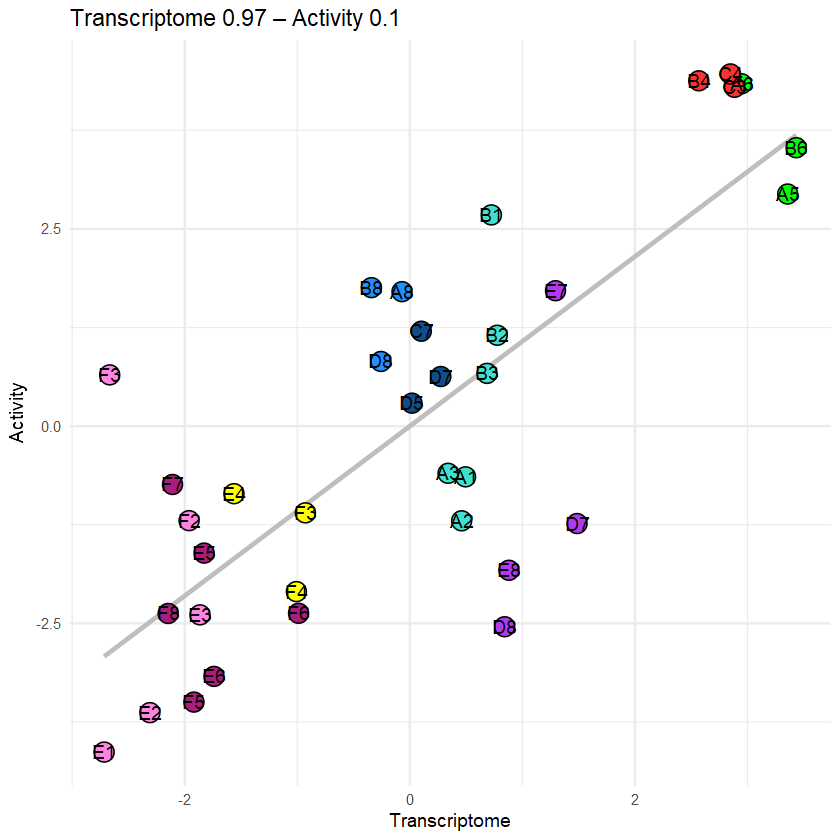

In [17]:
# Plot
p <- ggplot(df, aes(x = Transcriptome, y = Activity,color=color_2)) +

  # regression line
  geom_smooth(method = "lm", se = FALSE, color = "grey") +

  # normal points
  geom_point(aes(fill = color_2), shape = 21, color = "black", size = 5) +

  
  theme_minimal() +
  labs(x = "Transcriptome", y = "Activity",
       title = "Transcriptome 0.97 – Activity 0.1") +
  scale_fill_identity()+geom_text(aes(label = Well_ID), color="black")

p

ggsave(paste0('PLSR_X40_Y10_bt10000_MEA01_WGCAN097.pdf'),
                  width = 5.3,   # inches
                  height = 5,
                   plot=p)# inches


In [ ]:
#make cor network, the graph and compare with the SNAP program and save relevant things
#write.csv(df,"sample_loadings.csv")

In [19]:
# Extract loadings for X (WGCNA modules) and Y (MEA variables)
loadings_x <- as.data.frame(spls_res$loadings$X)
loadings_x <- tibble::rownames_to_column(loadings_x, var = "Variable")

loadings_y <- as.data.frame(spls_res$loadings$Y)
loadings_y <- tibble::rownames_to_column(loadings_y, var = "Variable")

# Extract variates (component scores)
variates_x <- as.data.frame(spls_res$variates$X)
variates_y <- as.data.frame(spls_res$variates$Y)

# Combine variates with sample information
sample_scores <- df  # already includes sample + component scores

# Create Excel sheets list
sheets_list <- list(
  "X_Loadings" = loadings_x,
  "Y_Loadings" = loadings_y,
  "Sample_Scores" = sample_scores
)

# Write to Excel
write_xlsx(sheets_list, path = "T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Analysis/MEA-seq/WGCNA_sPLSR/spls_results.xlsx")
